In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, string
import collections

from wordcloud   import WordCloud, STOPWORDS

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize


In [2]:
data = pd.read_csv('Tweets.csv')
data.shape

(14640, 15)

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
data.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Text(0, 0.5, 'Porcentaje')

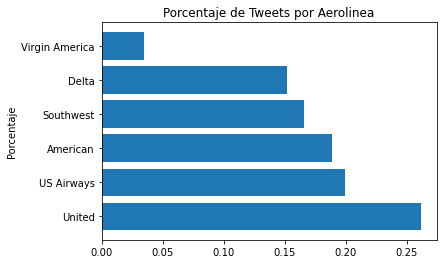

In [5]:
fig, ax = plt.subplots()
ax.barh(data['airline'].value_counts(normalize = True).index,data['airline'].value_counts(normalize = True).values)
ax.set_title("Porcentaje de Tweets por Aerolinea")
ax.set_ylabel("Porcentaje")



([<matplotlib.patches.Wedge at 0x254d3a0f648>,
 [Text(-0.4270504754628449, 1.0137198288516203, 'Negative'),
  Text(-0.11897122131710539, -1.0935473691149902, 'Neutral'),
  Text(0.961585420671111, -0.5341848731972505, 'Positive')],
 [Text(-0.23293662297973355, 0.5529380884645201, '62.7%'),
  Text(-0.06489339344569384, -0.5964803831536309, '21.2%'),
  Text(0.5245011385478787, -0.2913735671985002, '16.1%')])

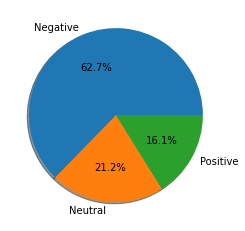

In [6]:
plt.pie(data['airline_sentiment'].value_counts(normalize=True),shadow=True,labels=['Negative','Neutral','Positive'],autopct='%1.1f%%')

In [7]:
data['tweet_long'] = data['text'].apply(lambda x : len(x))
data['tweet_long'].describe()

count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: tweet_long, dtype: float64

Text(0.5, 0.98, 'Distribución de la Longitud de los Tweets')

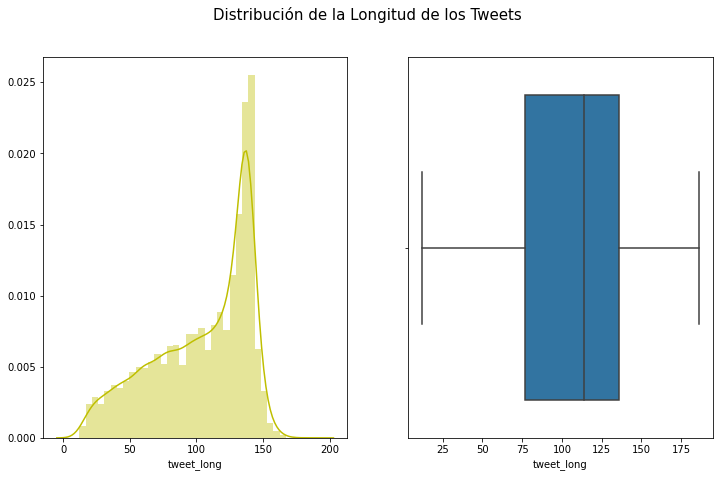

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,7))
sns.distplot(data['tweet_long'],ax=ax[0],color='y')
sns.boxplot(data['tweet_long'],orient='h',ax=ax[1])
fig.suptitle("Distribución de la Longitud de los Tweets", fontsize=15)

In [9]:

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~'), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('thanks', 'thank', text)
    text = re.sub('amp', 'it is not my problem', text)
    for i in ['virginamerica','americanair','usairways','southwestair','jetblue','united','flight']: 
        text = text.replace(i,'')
    
    return text

data['text_clean'] = data['text'].apply(lambda x : clean_text(x))


In [10]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['text_clean'] = data['text_clean'].apply(lambda x : remove_emoji(x))


In [11]:
stop_words=stopwords.words('english')
added_stop_words=["i'm",'u','ve','get']
for word in added_stop_words:
    stop_words.append(word)



In [12]:
tweet_list = [tweet for tweet in data['text_clean']]
lista=[]
for tweet in tweet_list:
    words = tweet.split()
    for word in words:
        lista.append(word)
pd.DataFrame(collections.Counter(lista).most_common(10),columns=['Palabra','Frecuencia']).style.background_gradient(cmap='Blues')

,Palabra,Frecuencia
0,to,8640
1,the,6046
2,i,5370
3,a,4475
4,you,4105
5,my,4019
6,for,3989
7,on,3775
8,and,3709
9,is,3573


In [13]:
#Visualizacion de las palabras mas comunes sin stop words
lista_no_stopWords = []
for tweet in tweet_list:
    words = tweet.split()
    for word in words:
        if word not in stop_words:
            lista_no_stopWords.append(word)
            
pd.DataFrame(collections.Counter(lista_no_stopWords).most_common(10),columns=['Palabra','Frecuencia']).style.background_gradient(cmap='Blues')

,Palabra,Frecuencia
0,thank,1672
1,cancelled,1057
2,service,951
3,help,854
4,time,768
5,problem,760
6,customer,744
7,us,678
8,hours,666
9,hold,637


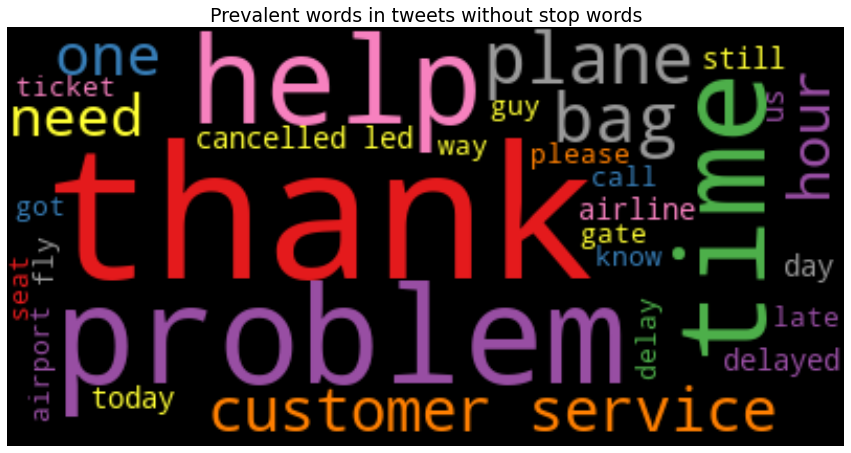

In [14]:
#Visualizacion de las principales palabras en los tweets sin stop words
text = ",".join(review for review in lista_no_stopWords)
wordcloud = WordCloud(max_words=30, colormap='Set1',background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.title('Prevalent words in tweets without stop words',fontsize=19)
plt.show()

In [15]:
#Visualización de las palabras más comunes según clasificación de Tweet en positivo
mask_positive = data['airline_sentiment'] == 'positive'
data['text_clean'].loc[mask_positive]
positive_tweet_list = [tweet for tweet in data['text_clean'].loc[mask_positive]]
list_positive=[]
for tweet in positive_tweet_list:
    words = tweet.split()
    for word in words:
        if word not in stop_words:
            list_positive.append(word)
            
pd.DataFrame(collections.Counter(list_positive).most_common(10),columns=['Palabra','Frecuencia']).style.background_gradient(cmap='Blues')

,Palabra,Frecuencia
0,thank,1062
1,great,233
2,service,159
3,love,137
4,customer,112
5,good,110
6,guys,110
7,much,109
8,best,105
9,awesome,99


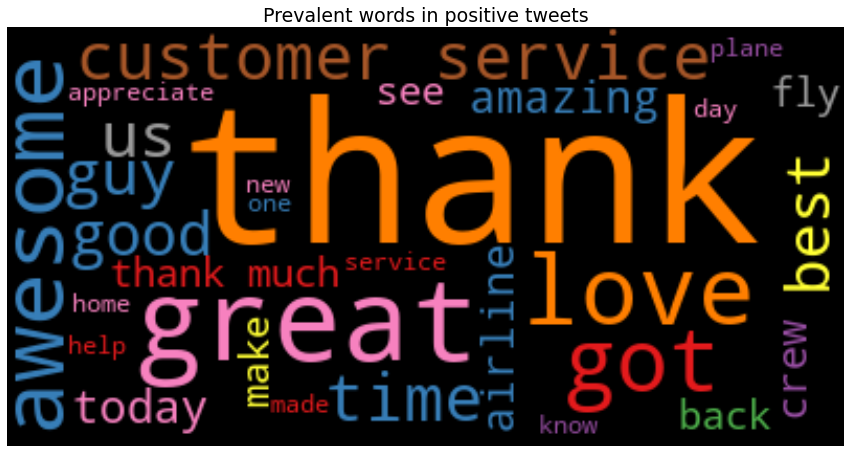

In [31]:
#Visualizacion de las principales palabras en los tweets positivos sin stop words
text = ",".join(review for review in list_positive if review!='problem')
wordcloud = WordCloud(max_words=30, colormap='Set1',background_color="black").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.title('Prevalent words in positive tweets',fontsize=19)
plt.show()

In [29]:
#Visualización de las palabras más comunes según clasificación de Tweet negativo
mask_negative = data['airline_sentiment'] == 'negative'
data['text_clean'].loc[mask_negative]
negative_tweet_list = [tweet for tweet in data['text_clean'].loc[mask_negative]]
list_negative=[]
for tweet in negative_tweet_list:
    words = tweet.split()
    for word in words:
        if word not in stop_words:
            list_negative.append(word)
            
pd.DataFrame(collections.Counter(list_negative).most_common(10),columns=['Palabra','Frecuencia']).style.background_gradient(cmap='Blues')

,Palabra,Frecuencia
0,cancelled,920
1,service,738
2,hours,641
3,help,610
4,hold,607
5,customer,604
6,time,582
7,problem,569
8,plane,515
9,delayed,493


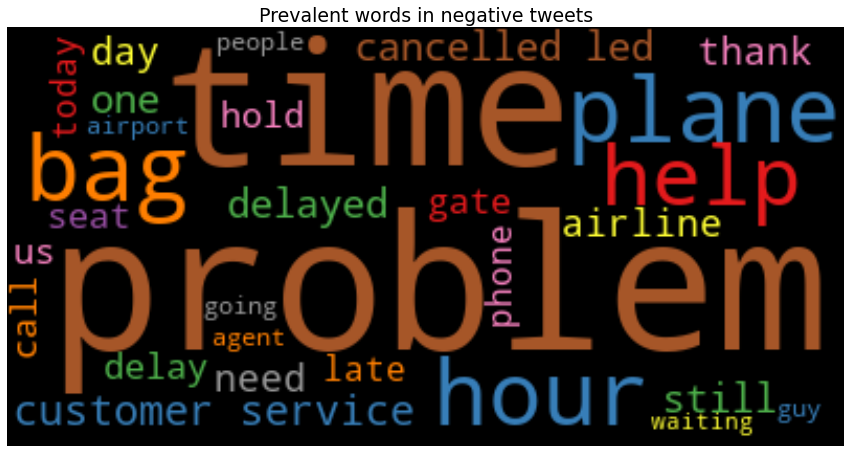

In [18]:
#Visualizacion de las principales palabras en los tweets negativos sin stop words
text2 = ",".join(review for review in list_negative)
wordcloud = WordCloud(max_words=30, colormap='Set1',background_color="black").generate(text2)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.title('Prevalent words in negative tweets',fontsize=19)
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
x = data['text_clean']
y = data['airline_sentiment']

train,test,y_train,y_test = train_test_split( x, y, stratify =y, random_state=49)



vectorizer=CountVectorizer(stop_words=stop_words,strip_accents='unicode')

x_train = vectorizer.fit_transform(train)
x_test = vectorizer.transform(test)

In [20]:
#model - LogisticRegression()
model = LogisticRegression(max_iter=250)
model.fit(x_train,y_train)

y_pred = model.predict(x_test)

In [21]:
accuracy_score(y_test,y_pred)

0.7852459016393443

In [22]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.83      0.90      0.86      2294
     neutral       0.64      0.57      0.60       775
    positive       0.74      0.63      0.68       591

    accuracy                           0.79      3660
   macro avg       0.74      0.70      0.72      3660
weighted avg       0.78      0.79      0.78      3660



In [23]:
confusion_matrix(y_test,y_pred)

array([[2058,  163,   73],
       [ 274,  441,   60],
       [ 134,   82,  375]], dtype=int64)

In [24]:
vectorizer=TfidfVectorizer(stop_words=stop_words,strip_accents='unicode');

X_tfidf_train=vectorizer.fit_transform(train);
X_tfidf_test=vectorizer.transform(test)


In [25]:
model = LogisticRegression(max_iter=150)
model.fit(X_tfidf_train,y_train)

y_pred = model.predict(X_tfidf_test)
accuracy_score(y_test,y_pred)

0.7762295081967213

In [26]:
confusion_matrix(y_test,y_pred)

array([[2168,   82,   44],
       [ 401,  336,   38],
       [ 175,   79,  337]], dtype=int64)

In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.79      0.95      0.86      2294
     neutral       0.68      0.43      0.53       775
    positive       0.80      0.57      0.67       591

    accuracy                           0.78      3660
   macro avg       0.76      0.65      0.69      3660
weighted avg       0.77      0.78      0.76      3660

